<h1><center>Generate Lensed Image</center></h1>

In [27]:
import numpy as np
import matplotlib.pyplot as plt

<h2>Calculate source image</h2>

Here we calculate an image size `imageSize**2` containing some number of galaxies `NumGalaxies`.

The "galaxies" are <a href="https://en.wikipedia.org/wiki/Gaussian_function">2D Gaussian functions</a> with a random angle between 0 and $2\pi$, a random peak brightness between 0 and 30 (arbitrary units) and random distribution widths in the $x$ and $y$ directions (`galaxy_xsig` and `galaxy_ysig`) between 2 and 9 (arbitrary units)

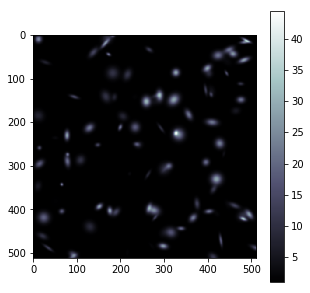

In [20]:
imageSize = int(512)
NumGalaxies = 100

x = np.arange(0, imageSize)
y = np.arange(0, imageSize)
X, Y = np.meshgrid(x, y)

source = np.ones((imageSize,imageSize))

galaxyPositions = imageSize*np.random.rand(NumGalaxies, 2)
#galaxySize = 30*np.random.rand(NumGalaxies)
galaxy_xsig = (2+7*np.random.rand(NumGalaxies))
galaxy_ysig = (2+7*np.random.rand(NumGalaxies))

galaxy_angle = 2*np.pi*np.random.rand(NumGalaxies)

galaxy_brightness = 30*np.random.rand(NumGalaxies)

a = np.cos(galaxy_angle)**2/(2*galaxy_xsig**2) +  np.sin(galaxy_angle)**2/(2*galaxy_ysig**2) 
b = - np.sin(2*galaxy_angle)/(4*galaxy_xsig**2) + np.sin(2*galaxy_angle)/(4*galaxy_ysig**2)
c = np.sin(galaxy_angle)**2/(2*galaxy_xsig**2) +  np.cos(galaxy_angle)**2/(2*galaxy_ysig**2)

for i, galaxyPos in enumerate(galaxyPositions):
    source += galaxy_brightness[i]*\
    np.exp(-(a[i]*(X-galaxyPos[0])**2 + 2*b[i]*(X-galaxyPos[0])*(Y-galaxyPos[1]) + c[i] * (Y-galaxyPos[1])**2))

sourceImg = source
    
plt.figure(figsize = (5,5))
plt.imshow(sourceImg, cmap = 'bone')
plt.colorbar()

#np.save("SourceImage.npy", sourceImg)

<h2>Calculate Deflection Angle</h2>

Following <a href = "http://www.ita.uni-heidelberg.de/~massimo/sub/Lectures/gl_all.pdf"> p. 10 of Introduction to Gravitational Lensing</a>, we consider point mass lense with potential

\begin{equation}
    \Phi = -\frac{GM}{r},
\end{equation}

with 

\begin{equation}
    r = \sqrt{b^2 + z^2},
\end{equation}
and 
\begin{equation}
    b = \sqrt{x^2 + y^2}.
\end{equation}

The deflection angle is then found to be

\begin{equation}
    \hat{\vec{\alpha}}(b) = \frac{4GM}{c^2b} \Big(
     \begin{matrix}
  \cos\phi \\
  \sin\phi
 \end{matrix}
 \Big),
\end{equation}

with 

\begin{equation}
\Big(
     \begin{matrix}
  x \\
  y
 \end{matrix}
 \Big) = 
 b\Big(
     \begin{matrix}
  \cos\phi \\
  \sin\phi
 \end{matrix}
 \Big)
\end{equation}

This allows us to calulate $\hat{\vec{\alpha}}$ as a function of $x$ and $y$.


In [21]:
mass = 5e8*2e30 # kg
G = 6.67408e-11
c = 3e8

xlens = np.linspace(-50, 50, imageSize)*1e+16
ylens = xlens
X,Y = np.meshgrid(xlens, ylens)

b = np.sqrt(X**2 + Y**2)

alphas = np.zeros(X.shape, dtype=object)

for i in range(imageSize):
    for j in range(imageSize):
        const = 4*G*mass/(c**2*b[i,j]**2)
        
        alpha_x = const*xlens[i]
        alpha_y = const*xlens[j]
        
        alphas[i,j] = np.array([alpha_x, alpha_y])

## Check deflection angle magnitudes

The magnitude of the deflection angle is expected to be given by

\begin{equation}
    |\hat{\vec{\alpha}}| = 2\frac{R_s}{b},
\end{equation}
where $R_s$ is the Schwarzschild radius which, for a point mass, is given by

\begin{equation}
    R_s = \frac{2GM}{c^2}.
\end{equation}

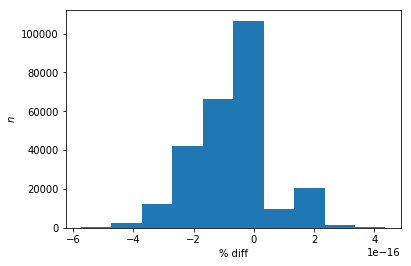

In [22]:
alphaMag1= np.zeros(alphas.shape)

for i in range(imageSize):
    for j in range(imageSize):
        alphaMag1[i,j] = sum(alphas[i,j]**2)**(1/2)
      
b = np.sqrt(X**2 + Y**2)
R_s = 2*G*mass/c**2

alphaMag2 = 2*R_s/b

diff = (alphaMag1-alphaMag2)/alphaMag1

plt.hist(diff.flatten());
plt.xlabel("% diff");
plt.ylabel("$n$");

## Apply Deflection

Choose some distance between the lense and the observer $D_L$. The new coordinates $(x', y')$ are given by

\begin{equation}
    x' = x + D_L\sin(\alpha_1),
\end{equation}

\begin{equation}
    y' = y + D_L\sin(\alpha_2).
\end{equation}

After calculating the new coordinates for an image of finite resolution, some pixels will now contain no "light" and the image will generally look weird. 

To resolve this we do a few things:

<ul>
    <li>After calculaing the new pixel positions we combine them into an image with a resolution lower than that of the original. In the case below the new resolution is half that of the original.</li>
    <li> Remove set all pixels with values below some low value to zero </li>
    <li> Apply a smoothing filter. </li>
</ul>

In [23]:
# Distance to lens
D_L = 50*3.1e19 # m 

numbins = int(imageSize/2)
bins = np.linspace(min(xlens), max(xlens)+(max(xlens)-min(xlens))/numbins, numbins)
newImage = np.zeros((numbins, numbins))
dudcount = 0

xindexList = np.zeros(imageSize**2)
yindexList = np.zeros(imageSize**2)
for i in range(imageSize):
    for j in range(imageSize):
        newx = xlens[i] + np.sin(alphas[i,j][0])*D_L
        newy = ylens[j] + np.sin(alphas[i,j][1])*D_L
        
        xmask = (newx <= max(xlens) and newx >= min(xlens))
        ymask = (newy <= max(xlens) and newy >= min(xlens))
        
        if xmask and ymask:
            
            xindex = np.where(abs(bins-newx) == min(abs(bins-newx)))[0]
            yindex = np.where(abs(bins-newy) == min(abs(bins-newy)))[0]
            newImage[xindex, yindex] += sourceImg[i,j]
            xindexList[i*imageSize+j] = xindex
            yindexList[i*imageSize+j] = yindex
            
        else:
            dudcount += 1
        print(i,  end = '\r')
    
print("{}/{} duds".format(dudcount, imageSize**2))

8596/262144 duds


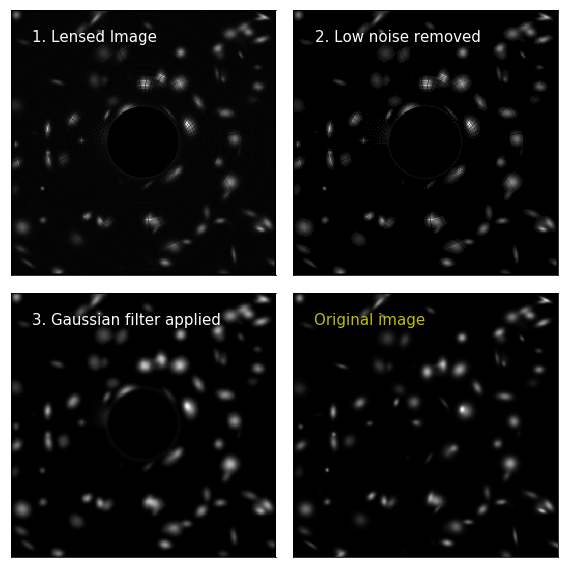

In [28]:
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Plot initial lensed image
ax1.imshow(newImage+1, cmap = "binary_r")
ax1.annotate("1. Lensed Image", (20,30), color = "w", size = 15)

# Remove low level weirdness 
weirdness_removed = np.zeros(newImage.shape) 
weirdness_removed[newImage>10] += newImage[newImage>10]
ax2.imshow(weirdness_removed, cmap = "binary_r")
ax2.annotate("2. Low noise removed", (20,30), color = "w", size = 15)

# Smooth slightly 
from scipy.ndimage import gaussian_filter

# (Optional) Add noise 
# noise = 0.04*np.asarray(np.random.randn(len(weirdness_removed[:,0]),
#                                        len(weirdness_removed[:,0])))
finalImage = gaussian_filter(weirdness_removed, sigma=1.4) #+ noise      

ax3.imshow(finalImage, cmap = "binary_r")
ax3.annotate("3. Gaussian filter applied", (20,30), color = "w", size = 15)

ax4.imshow(sourceImg, cmap = "binary_r")
ax4.annotate("Original image", (40,60), color = "y", size = 15)

# Remove axis ticks
ax1.set_xticks([]) ;ax1.set_yticks([])
ax2.set_xticks([]) ;ax2.set_yticks([])
ax3.set_xticks([]) ;ax3.set_yticks([])
ax4.set_xticks([]) ;ax4.set_yticks([])

plt.tight_layout()
np.save("FinalImage.npy", finalImage)
np.save("SourceImage.npy", sourceImg)